In [1]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

torch.set_default_dtype(torch.float64)

DEVICE = torch.device("cpu")

In [2]:
import gym
env = gym.make('LunarLander-v2')

/home/ototot/anaconda3/envs/ML/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [4]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.DoubleTensor(state).to(DEVICE))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [5]:
network = PolicyGradientNetwork().to(DEVICE)
agent = PolicyGradientAgent(network)

In [6]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 30 # 每蒐集 30 個 episodes 更新一次 agent
NUM_BATCH = 500        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

for batch in tqdm(range(NUM_BATCH)):

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards += [total_reward] * total_step  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs).to(DEVICE), torch.from_numpy(rewards).to(DEVICE))

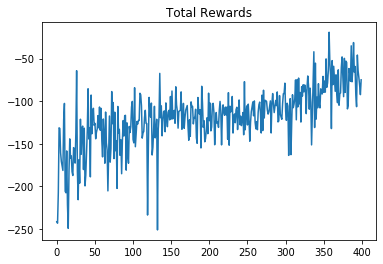

In [7]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

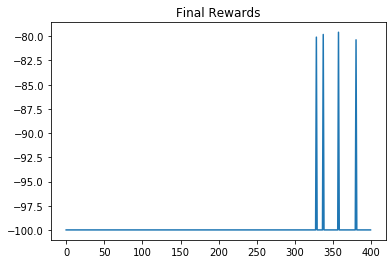

In [8]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

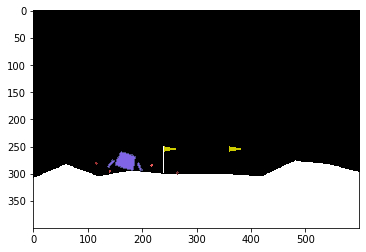

In [9]:
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [10]:
print(total_reward)

-97.86502418052493
